In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 2s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['yes' 'right' 'stop' 'go' 'no' 'up' 'left' 'down']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/up/76424fa5_nohash_0.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

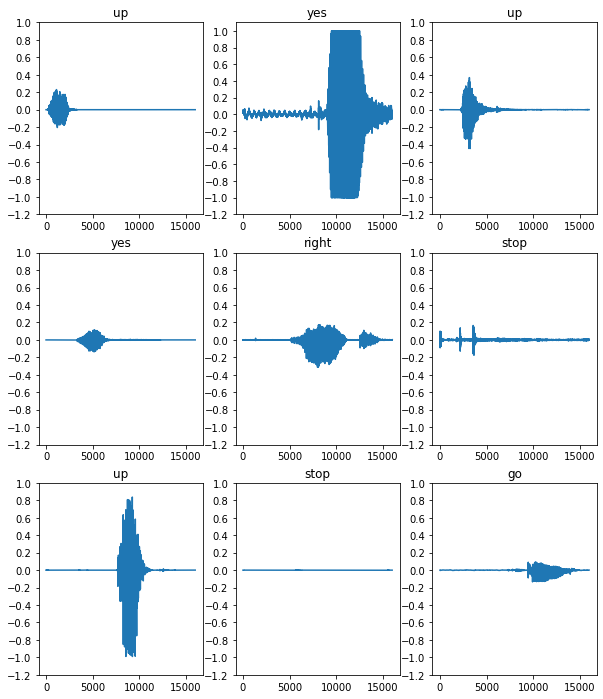

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  print(equal_length.shape)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)
  print(spectrogram.shape)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
print(waveform)
print(spectrogram)
display.display(display.Audio(waveform, rate=16000))

(16000,)
(124, 129)
Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback
tf.Tensor(
[ 0.0000000e+00 -6.1035156e-05 -6.1035156e-05 ...  9.1552734e-05
  3.0517578e-05  3.0517578e-05], shape=(16000,), dtype=float32)


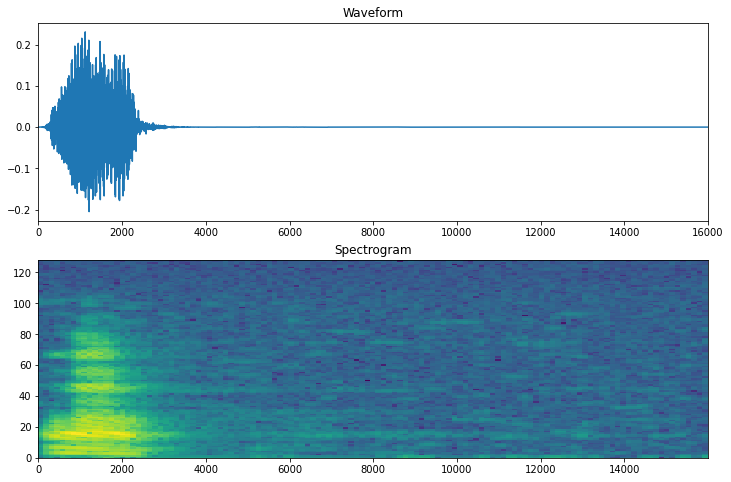

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
waveform.shape[0]

NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py
import numpy as np

In [4]:
!pip install obspy

     |████████████████████████████████| 24.7 MB 68 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp37-cp37m-linux_x86_64.whl size=21667947 sha256=2b7afed73a992e540bc061c828784c9f5ba7d4ecca70154c7fd96020d12f1d60
  Stored in directory: /root/.cache/pip/wheels/28/7e/ea/0a37d5f5001d096cf97d6527b60300badd2d0074449e89c736
Successfully built obspy


In [5]:
import obspy
import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

In [6]:
def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream

    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream

In [7]:
import pandas as pd
import numpy as np
def getSamples(fileName, setStart, setEnd, startIndex, endIndex):
  # fileName: like 'drive/Shareddrives/anomalyResearch/chunk1/chunk1.hdf5'
  # setStart: start index of dataset chosen
  # setEnd: end index of dataset chosen
  # startIndex: start position of choosen slide window
  # endIndex: end position of choosen slide window
  file_name = fileName
  dtf1 = h5py.File(file_name,'r')
  data_group = dtf1["data"]

  data_keys = list(data_group.keys())
  fileList = data_keys[setStart:setEnd]

  sample_list = []
  #time_list = []
  for i in range(len(fileList)):
     sub_name = "data/" + fileList[i] + ""
     #print(sub_name)
     dataset = dtf1.get(sub_name)
     st = make_stream(dataset)
     #print(max(st[2]))
     st_list = list(st[2][startIndex:endIndex])
     #spectrogram = tf.math.abs(tf.signal.stft(st_list, frame_length=1000, frame_step=100))
     #spec_array = spectrogram.numpy().reshape(51*513)
     #spec = spec_array.tolist()
     sample_list.extend(st_list)
     #timestart = fileList[i][8:12] + "-" + fileList[i][12:14] + "-" + fileList[i][14:16] + " " + fileList[i][16:18] + ":" + fileList[i][18:20] + ":00" 
     #print(timestart)
     #time1 = np.datetime64(timestart, 'ms')
     #timeStamp = pd.date_range(time1, freq='10L', periods=6000).strftime("%Y-%m-%d %H:%M:%S").tolist()
     #time_list.extend(timeStamp[startIndex:endIndex])

  return sample_list

In [8]:
fileName = 'drive/Shareddrives/anomalyResearch/chunk1/chunk1.hdf5'

noise_train = getSamples(fileName=fileName, setStart=0, setEnd=1, startIndex=500, endIndex=2500)

In [9]:
len(noise_train)

2000

In [10]:
fileName = 'drive/Shareddrives/anomalyResearch/chunk3/chunk3.hdf5'

earth_train = getSamples(fileName=fileName, setStart=5000, setEnd=5001, startIndex=0, endIndex=2000)

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  #zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  #equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      waveform, frame_length=500, frame_step=50)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
spectrogram = get_spectrogram(earth_train)

In [11]:
waveform_earth = tf.cast(earth_train, tf.float32)

In [12]:
waveform_noise = tf.cast(noise_train, tf.float32)

In [13]:
# new method
spectrograms_earth = tf.signal.stft(waveform_earth,
                              frame_length=500,
                              frame_step=50)
magnitude_spectrograms_earth = tf.abs(spectrograms_earth)

In [14]:
# new method
spectrograms_noise = tf.signal.stft(waveform_noise,
                              frame_length=500,
                              frame_step=50)
magnitude_spectrograms_noise = tf.abs(spectrograms_noise)

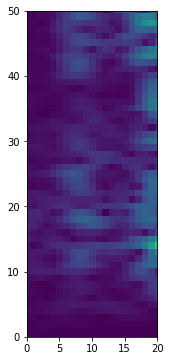

In [22]:
#plt.figure()
plt.figure(figsize=(8,6))
plt.imshow(tf.transpose(magnitude_spectrograms_earth), origin='lower')
plt.xlim([0, 20])
plt.ylim([0, 50])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 10, 20, 30, 40, 50])
#plt.xlim([0, 20])
#plt.ylim([0, 50])
plt.show()

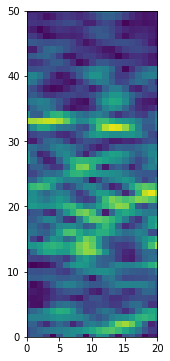

In [24]:
#plt.figure()
plt.figure(figsize=(8,6))
plt.imshow(tf.transpose(magnitude_spectrograms_noise), origin='lower')
plt.xlim([0, 20])
plt.ylim([0, 50])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 10, 20, 30, 40, 50])
#plt.xlim([0, 20])
#plt.ylim([0, 50])
plt.show()

In [ ]:
spectrogram = tf.math.abs(tf.signal.stft(waveform, frame_length=1000, frame_step=100))

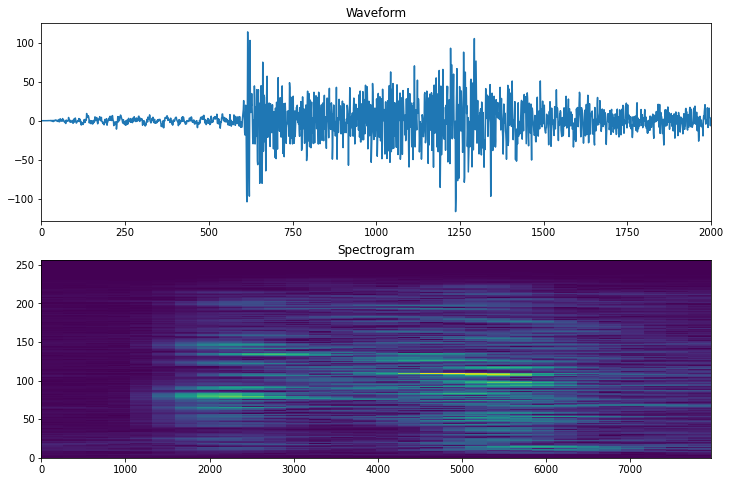

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  
  #log_spec = np.log(spectrogram.T)
  log_spec = spectrogram.T
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 2000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()

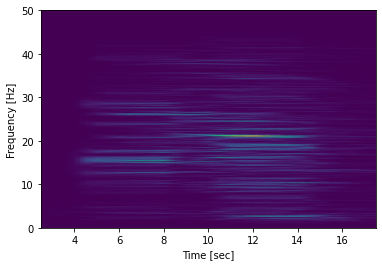

In [ ]:
f,t,Sxx = signal.spectrogram(waveform, fs=100, window=('tukey', 0.25), nperseg=500, noverlap=450, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, mode='psd')
#f,t,Sxx = signal.spectrogram(waveform, fs=100, nperseg=500, noverlap=450, nfft=None)
#plt.figure(figsize=(8,6))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [33]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [ ]:
fs = 20

In [ ]:
waveform = tf.cast(noise_train, tf.float32)

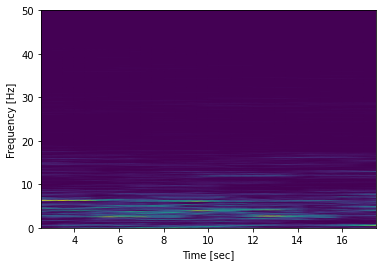

In [ ]:
f,t,Sxx = signal.spectrogram(waveform, fs=100, window=('tukey', 0.25), nperseg=500, noverlap=450, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, mode='psd')
#f,t,Sxx = signal.spectrogram(waveform, fs=100, nperseg=500, noverlap=450, nfft=None)
#plt.figure(figsize=(8,6))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
spectrogram1 = tf.math.abs(tf.signal.stft(noise_train, frame_length=1000, frame_step=100))

In [ ]:
spectrogram2 = tf.math.abs(tf.signal.stft(earth_train, frame_length=1000, frame_step=100))

In [ ]:
print(spectrogram2)

tf.Tensor(
[[  4.40824890e+00   1.42167273e+01   2.73343105e+01 ...,   2.05113105e-02
    2.39542522e-03   1.11389160e-03]
 [  3.22050476e+00   1.48639441e+01   2.55757923e+01 ...,   1.56076504e-02
    8.90757481e-04   1.32751465e-03]
 [  1.67138672e+00   1.40289297e+01   2.28671341e+01 ...,   1.36873825e-02
    3.30835790e-03   2.19726562e-03]
 ..., 
 [  6.91575050e-01   1.08320475e+01   3.24463921e+01 ...,   9.19377059e-03
    2.74993642e-03   1.16252899e-03]
 [  3.18961048e+00   8.42590427e+00   2.83557777e+01 ...,   8.60093255e-03
    3.47902835e-03   4.01496887e-04]
 [  5.40740681e+00   5.70875835e+00   2.18802605e+01 ...,   9.24905762e-03
    3.81681812e-03   2.77757645e-04]], shape=(51, 513), dtype=float32)


In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [ ]:
print(noise_train)

[-0.0, -0.027729943, -0.082377531, -0.22440138, -0.31890735, -0.48586959, -0.54866952, -0.54567862, -0.53534615, -0.5441348, -0.66233462, -0.4868902, -0.50456715, -0.060710538, 0.36327738, 0.70543754, 0.56390625, 0.42390621, 0.12821563, -0.25448817, -0.19992027, -0.024102738, -0.28384376, -0.35919446, 0.069064498, 0.68762046, 1.3167775, 2.5309331, 3.3565135, 2.6377075, 1.8338577, 1.3663225, 1.0659963, 0.63293666, 1.5958116, 3.5133324, 5.0621629, 7.8688645, 10.880054, 13.357828, 14.284266, 13.331296, 11.150562, 8.3124762, 6.824966, 4.4762664, 3.8725669, 5.5990138, 5.0680804, 5.0020475, 6.3695121, 7.8233757, 5.7130718, 3.5941243, 5.0008817, 3.3505373, 2.3121612, 6.2769766, 11.045135, 11.737217, 12.277122, 14.159863, 11.341599, 7.5680704, 8.9732018, 11.471324, 8.270812, 5.009233, 2.2551255, -2.5803301, -4.0250459, 3.8420584, 16.233305, 23.942942, 29.540524, 25.812887, 15.597115, 7.632618, 5.5334444, 12.532688, 22.39546, 34.754162, 40.768906, 40.059395, 34.240997, 25.939438, 21.14949, 10.5

ValueError: ignored

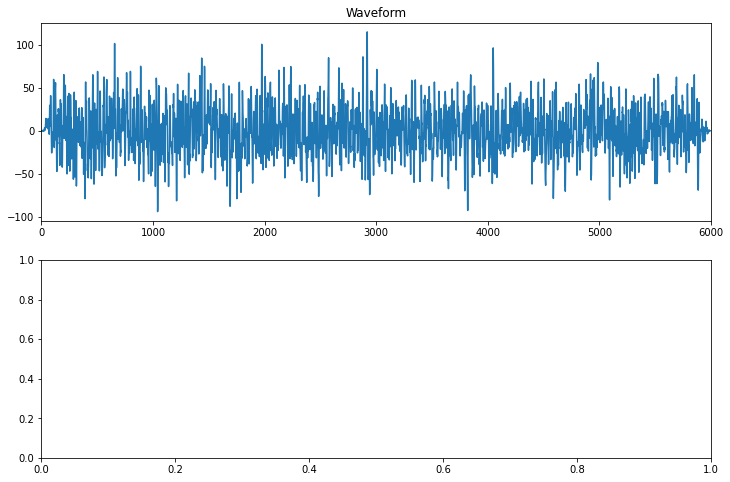

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(6000)
axes[0].plot(timescale, np.array(noise_train))
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

plot_spectrogram(np.array(noise_train).reshape(51,513), axes[1])
#plot_spectrogram(spectrogram1.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

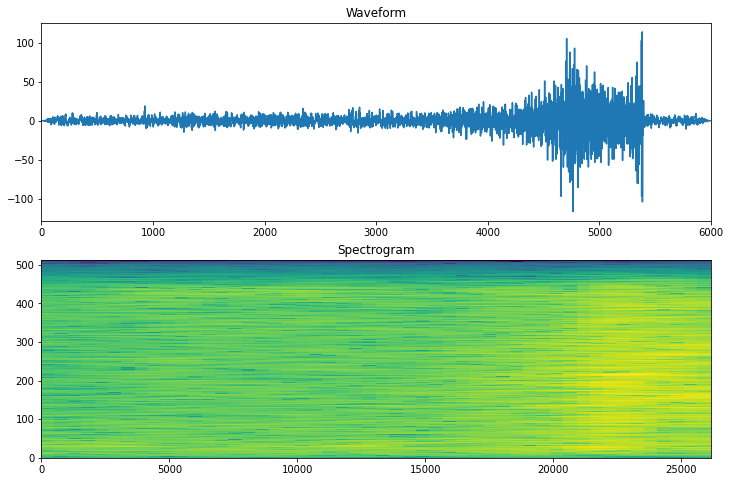

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(6000)
axes[0].plot(timescale, np.array(earth_train)[::-1])
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

#plot_spectrogram(spe2.reshape(51,513), axes[1])
plot_spectrogram(spectrogram2.numpy()[::-1], axes[1])
axes[1].set_title('Spectrogram')
plt.show()

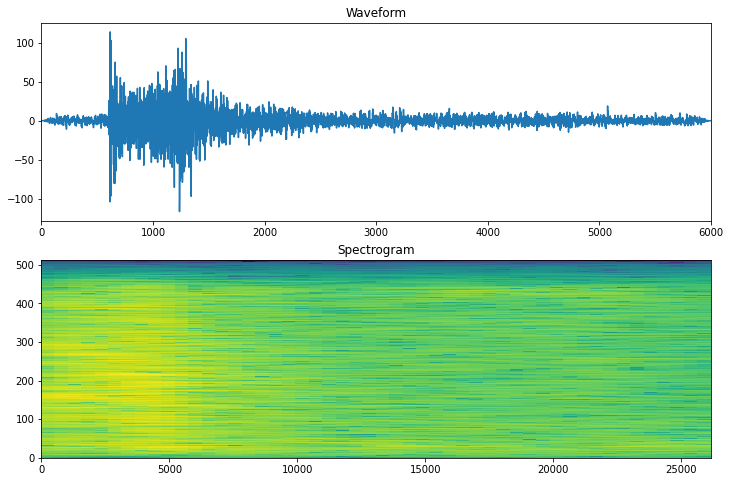

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(6000)
axes[0].plot(timescale, np.array(earth_train))
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

#plot_spectrogram(spe2.reshape(51,513), axes[1])
plot_spectrogram(spectrogram2.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [25]:
import pandas as pd

data = pd.read_csv('drive/Shareddrives/anomalyResearch/selfBACK/t/upstairs/026.csv')
print(data)

                         time         x         y         z     class
0     2016-04-13 11:12:19.462 -0.984375 -0.109375  0.187500  upstairs
1     2016-04-13 11:12:19.472 -0.984375 -0.125000  0.218750  upstairs
2     2016-04-13 11:12:19.482 -0.953125 -0.140625  0.218750  upstairs
3     2016-04-13 11:12:19.493 -0.968750 -0.156250  0.187500  upstairs
4     2016-04-13 11:12:19.503 -0.984375 -0.203125  0.187500  upstairs
...                       ...       ...       ...       ...       ...
8159  2016-04-13 11:13:43.452 -0.875000 -0.484375  0.234375  upstairs
8160  2016-04-13 11:13:43.462 -0.937500 -0.500000  0.234375  upstairs
8161  2016-04-13 11:13:43.472 -1.015625 -0.484375  0.171875  upstairs
8162  2016-04-13 11:13:43.483 -1.109375 -0.421875  0.093750  upstairs
8163  2016-04-13 11:13:43.493 -1.218750 -0.375000  0.046875  upstairs

[8164 rows x 5 columns]


In [26]:
data_back = data['z']
data_back = data_back[0:2000]

In [27]:
waveform_back = tf.cast(data_back, tf.float32)

In [30]:
# new method
spectrograms_back = tf.signal.stft(waveform_back,
                              frame_length=500,
                              frame_step=50)
magnitude_spectrograms_back = tf.abs(spectrograms_back)

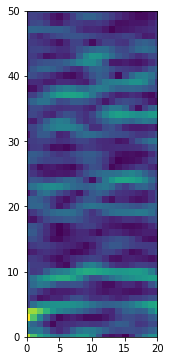

In [31]:
#plt.figure()
plt.figure(figsize=(8,6))
plt.imshow(tf.transpose(magnitude_spectrograms_back), origin='lower')
plt.xlim([0, 20])
plt.ylim([0, 50])
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 10, 20, 30, 40, 50])
#plt.xlim([0, 20])
#plt.ylim([0, 50])
plt.show()

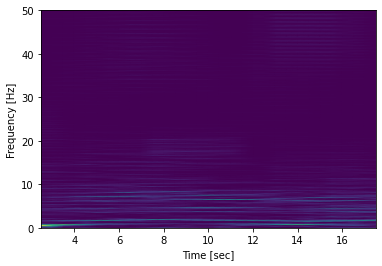

In [34]:
f,t,Sxx = signal.spectrogram(waveform_back, fs=100, window=('tukey', 0.25), nperseg=500, noverlap=450, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, mode='psd')
#f,t,Sxx = signal.spectrogram(waveform, fs=100, nperseg=500, noverlap=450, nfft=None)
#plt.figure(figsize=(8,6))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
back_spec = tf.math.abs(tf.signal.stft(data_back, frame_length=1000, frame_step=100))

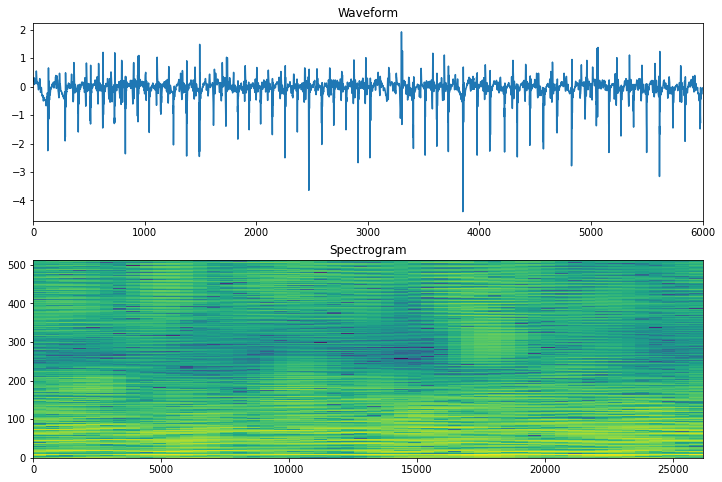

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(6000)
axes[0].plot(timescale, np.array(data_back))
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

#plot_spectrogram(spe2.reshape(51,513), axes[1])
plot_spectrogram(back_spec.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

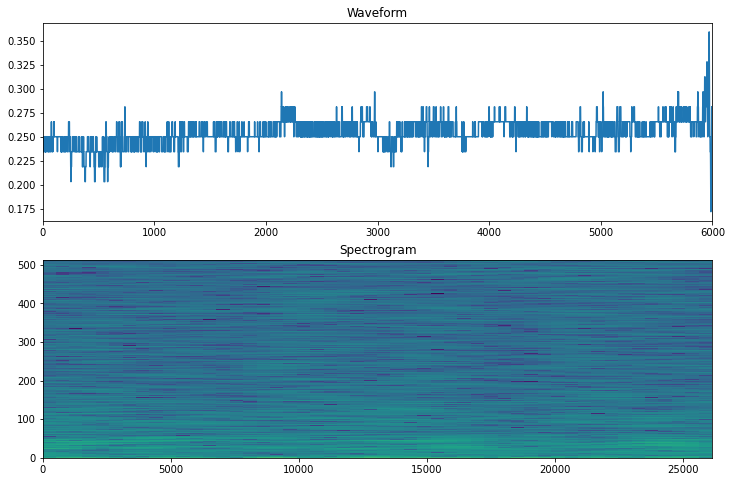

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(6000)
axes[0].plot(timescale, np.array(data_back)[::-1])
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

#plot_spectrogram(spe2.reshape(51,513), axes[1])
plot_spectrogram(back_spec.numpy()[::-1], axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
tf.math.abs(tf.signal.stft(x, frame_length, frame_step))
# frame_length number of samples in 5-10 seconds of data
# frame_step number of samples in 0.1s-1s data